In [1]:
#BC
# Import python modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import imp
import os
import glob
import sys
import time
from pyDOE import *

## Import Codes and Prepare Input Arrays

In [5]:
#BC
# Define path to the codes
sygmadir = 'C:/Users/carli/Documents/Astrophysics General/iCER ACRES/Chemical Evolution Code/NuPyCEE'
jinapydir = 'C:/Users/carli/Documents/Astrophysics General/iCER ACRES/Chemical Evolution Code/JINAPyCEE'
cagadir = 'C:/Users/carli/Documents/Astrophysics General/iCER ACRES/Chemical Evolution Code/caga/caga'

#on HPCC: /mnt/home/f0008572/Chem_Evol_Code/...

# Set the environments to let Python knows where are the codes
os.environ['CAGADIR'] = cagadir
os.environ['SYGMADIR'] = sygmadir
os.environ['JINAPYDIR'] = jinapydir

# Import the codes
caga  = imp.load_source('caga', cagadir+'/caga.py')
calc  = imp.load_source('calc', cagadir+'/calc.py')
plot  = imp.load_source('plot', cagadir+'/plot.py')
sygma = imp.load_source('sygma', sygmadir+'/sygma.py')
omega = imp.load_source('omega', sygmadir+'/omega.py')
gamma = imp.load_source('gamma', jinapydir+'/gamma.py')

In [6]:
#BC
# Get the file name for the host tree (Milky-Way-like halo)
hostID = 686
hostfname = cagadir+"/../notebooks/H1725272_LX11/rsid{}.npy".format(hostID)

# Get the file names for the satellite sub-trees
# Below, the host tree will be removed from that list
subfnames = glob.glob(cagadir+"/../notebooks/H1725272_LX11/*")

# Convert \ into /, (happens sometime with Windows machines)
for i in range(len(subfnames)):
#    i_char = subfnames[i].index("\\")
#    temp = ""
#    for j in range(i_char):
    i_char = subfnames[i].index("\\")
    temp = subfnames[i][:i_char]
    temp += "/"
    temp += subfnames[i][i_char+1:]
    subfnames[i] = temp
    #print(subfnames[i])

#for i in subfnames:
#    j = i.index("\\")
#    i[j] = "/"
#    print(i,j)
# Remove the host tree file name from the sub-tree file names
subfnames.remove(hostfname)
print(len(subfnames),'sub-trees found')

21 sub-trees found


In [7]:
#BC
# Load the GAMMA input arrays for each tree
host_tree = caga.gamma_tree.load(hostfname)
sub_trees = [caga.gamma_tree.load(subfname) for subfname in subfnames]

In [8]:
#BC
# Precalculate stellar populations to accelerate GAMMA computing time
SSPs_in = caga.precompute_ssps()

OMEGA run in progress..
SYGMA run in progress..
   SYGMA run completed - Run time: 0.23s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.06s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.09s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.11s
Warning -- Not enough gas to sustain the SFH. 2
   OMEGA run completed - Run time: 4.25s


# GAMMA SAMPLING

In [9]:
#BC
# Function to gather paramaters and run GAMMA
def run_gamma(gt, mvir_thresh, gamma_kwargs, SSPs_in):
    kwargs = caga.generate_kwargs(gt, mvir_thresh, SSPs_in=SSPs_in)
    kwargs.update(gamma_kwargs)
    g = gamma.gamma(**kwargs)
    return g

# Function to return the correctly-scaled parameters
# for trees, as a function of their final dark matter mass
def get_input_sfe(sfe, m_DM_final, sfe_m_index):
    print(sfe)
    return sfe / (m_DM_final / m_DM_0_ref)**sfe_m_index
def get_input_mass_loading(mass_loading, m_DM_final, exp_ml):
    print(mass_loading)
    c_eta = mass_loading * m_DM_0_ref**(exp_ml/3.0)
    return c_eta * m_DM_final**(-exp_ml/3.0)
    

In [10]:
#BC
# Parameters that SHOULD NOT be modified
# They are to activate certain parts of the code
# to accept the parameters mentionned above
C17_eta_z_dep = False
DM_outflow_C17 = True
sfe_m_dep = True
t_star = -1
t_inflow = -1

# Set the dark matter halo at redshift 0 where
# the parameters will be refering to.
# SHOULD NOT be modified
m_DM_0_ref = 1.0e12

# Minimium virial halo mass below which no star formation can occur
# This will likely disapear soon, so should not be part of the Gaussian process
mvir_thresh = 3e7

## LATIN HYPERCUBE SAMPLING TO CHOSE PARAMETER VALUES 
##### Make an array for each point/set of input values, then put those arrays into one array or list to later loop through one set of values will equal one GAMMA run
#### Parameters to be explored and their ranges
index 0 - t_ff_index = 0.0 - 2.0  
index 1 - f_t_ff = 1.0 - 10.0   
index 2 - sfe_m_index = -1.0 - 1.0  
index 3 - sfe = 0.001 - 0.1   
index 4 - f_dyn = 0.05 - 0.5  
index 5 - t_sf_z_dep = 0.0 - 2.0  
index 6 - exp_ml = 0.0 - 2.0  
index 7  - mass_loading = 0.0 - 2.0 - UPDATE ON HPCC (it's 50.0)   
index 8 - f_halo_to_gal_out = 0.0 - 1.0  
index 9 - nb_1a_per_m = 0.8e-3 - 2.0e-3  

In [11]:
#dict
# Parameters to be sampled
# var_range['dictionary_key'][0] -- minimum parameter value
# var_range['dictionary_key'][1] -- range (max - min)
var_range = {}
var_range["t_ff_index"] = [0.0, 2.0]
var_range["f_t_ff"] = [1.0, 10.0] #
var_range["sfe_m_index"] = [-1.0, 1.0] #
var_range["sfe"] = [.001, .1]#
var_range["f_dyn"] = [.05, .5]
var_range["t_sf_z_dep"] = [0.0,2.0]
var_range["exp_ml"] = [0.0,2.0]
var_range["mass_loading"] = [0.0,2.0] #
var_range["f_halo_to_gal_out"] = [0.0,1.0]
var_range["nb_1a_per_m"] = [0.8e-3,1.2e-3]

In [12]:
#intitialize output arrays here
#emsp = np.array([[1.25069381e+00,2.30532770e+00,-9.93529188e-01,6.83757192e-02,1.81205406e-01,1.10099486e+00,1.29994641e+00,2.42354994e-01,5.83291104e-01,1.38023899e-03]])
#Candidates: t_sf_z_dep, exp_ml
#emsp = np.array([em_sampledpoints[0], em_sampledpoints[7]])

sampled_points = 1 #increase as going on with testing
num_gal_1 = len(sub_trees)+1
gal_Mstar_1 = np.empty([sampled_points, num_gal_1])
gal_FeH_mean_1 = np.empty([sampled_points, num_gal_1])
gal_FeH_std_1 = np.empty([sampled_points, num_gal_1])

In [13]:
num_gal_2 = len(sub_trees)+1
gal_Mstar_2 = np.empty([sampled_points, num_gal_2])
gal_FeH_mean_2 = np.empty([sampled_points, num_gal_2])
gal_FeH_std_2 = np.empty([sampled_points, num_gal_2])

In [14]:
#ONLY RUN THIS ONCE UNLESS YOU WANT THIS TO BE CHANGED
dimensions = len(var_range) #aka number of parameters
lhd_temp = lhs(dimensions, samples=sampled_points)

In [15]:
var_range_2 = np.zeros([dimensions,2])

#minimum of certain variables, if not zero
var_range_2[1][0] = 1.0 #f_t_ff
var_range_2[2][0] = -1.0 #sfe_m_index
var_range_2[3][0] = .001 #sfe
var_range_2[4][0] = .05 #f_dyn
var_range_2[9][0] = .0008 #nb_1a_per_m

#normalization factor of all variables = max - min
var_range_2[0][1] = 2.0 #t_ff_index
var_range_2[1][1] = 10.0 - var_range_2[1][0] #f_t_ff
var_range_2[2][1] = 1.0 - var_range_2[2][0] #sfe_m_index
var_range_2[3][1] = .1 - var_range_2[3][0] #sfe
var_range_2[4][1] = .5 - var_range_2[4][0] #f_dyn
var_range_2[5][1] = 2.0 #t_sf_z_dep
var_range_2[6][1] = 2.0 #exp_ml
var_range_2[7][1] = 2.0 #mass_loading
var_range_2[8][1] = 1.0 #f_halo_to_gal_out
var_range_2[9][1] = .002 - var_range_2[9][0] #nb_1a_per_m

gal_Mstar = np.empty([sampled_points, num_gal_1])
gal_FeH_mean = np.empty([sampled_points, num_gal_1])
gal_FeH_std = np.empty([sampled_points, num_gal_1])
em_sample_points_2 = np.copy(lhd_temp)
for i in range(0, sampled_points):
    for dim in range(0,dimensions):
        em_sample_points_2[i][dim] = (lhd_temp[i][dim]*(var_range_2[dim][1]))+var_range_2[dim][0]

In [16]:
#dict
for key in var_range.keys():
    print(var_range[key])

[0.0, 2.0]
[1.0, 9.0]
[-1.0, 1.0]
[0.001, 0.099]
[0.05, 0.45]
[0.0, 2.0]
[0.0, 2.0]
[0.0, 2.0]
[0.0, 1.0]
[0.0008, 0.0012]


In [17]:
#dict
lhd_1 = []
em_sample_points_1 = []
for i in range(0, sampled_points):
    j = 0
    lhd_1.append({})
    em_sample_points_1.append({})
    for key in var_range.keys():
        lhd_1[i][key] = lhd_temp[i][j]
        j += 1

In [18]:
# Fill the em_sample_points array
for i in range(0, sampled_points):
    for key in var_range.keys():
        em_sample_points_1[i][key] = (lhd_1[i][key]*(var_range[key][1]))+var_range[key][0]

### GAMMA runs and output extraction 

In [27]:
#dict version
print("GAMMA sample #: "+str(i))
start = time.time()

# Get the default "empty" list of parameters
gamma_kwargs_1 = {"print_off":True, "C17_eta_z_dep":C17_eta_z_dep, \
    "DM_outflow_C17":DM_outflow_C17, "t_star":t_star, \
        "t_inflow":t_inflow, "sfe_m_dep":sfe_m_dep }

# Add the sampled parameters
for key in var_range.keys():
    gamma_kwargs_1[key] = copy.deepcopy(em_sample_points_1[i][key])
    
print("sfe: " + str(em_sample_points_1[i]["sfe"]))
print("gamma sfe: " + str(gamma_kwargs_1["sfe"]))

gamma_kwargs_1["sfe"] = get_input_sfe(em_sample_points_1[i]["sfe"],host_tree.m_DM_0, em_sample_points_1[i]["sfe_m_index"])
gamma_kwargs_1["mass_loading"] = get_input_mass_loading(em_sample_points_1[i]["mass_loading"],host_tree.m_DM_0, em_sample_points_1[i]["exp_ml"])

print("sfe: " + str(em_sample_points_1[i]["sfe"]))
print("gamma sfe: " + str(gamma_kwargs_1["sfe"]))

# Run GAMMA for the host tree
ghost = run_gamma(host_tree, mvir_thresh, gamma_kwargs_1, SSPs_in)

print("sfe: " + str(em_sample_points_1[i]["sfe"]))
print("gamma sfe: " + str(gamma_kwargs_1["sfe"]))

# Run GAMMA for the every sub-trees 
gsubs = []
for i_sub in range(len(sub_trees)):
    gamma_kwargs_1["sfe"] = get_input_sfe(em_sample_points_1[i]["sfe"], sub_trees[i_sub].m_DM_0, em_sample_points_1[i]["sfe_m_index"])
    gamma_kwargs_1["mass_loading"] = get_input_mass_loading(em_sample_points_1[i]["mass_loading"],sub_trees[i_sub].m_DM_0,  em_sample_points_1[i]["exp_ml"])
    gsubs.append(run_gamma(sub_trees[i_sub], mvir_thresh, gamma_kwargs_1, SSPs_in))

print("sfe: " + str(em_sample_points_1[i]["sfe"]))
print("gamma sfe: " + str(gamma_kwargs_1["sfe"]))
#=========================
#  Extraction of outputs
#=========================
# add output processing here and put it in an array where host galaxy is very last entry in each row, 
# ie. x[i][-1] should be the host galaxy value

len_gsubs = len(gsubs)

# Extract the final (uncorrected) stellar mass of each tree
for j in range(len_gsubs):
    gal_Mstar_1[i][j] = calc.mstar_evolution(gsubs[j])[-1]#check on this output
gal_Mstar_1[i][-1] = calc.mstar_evolution(ghost)[-1]

# Extract the metallicity distribution function (MDF) of each tree
# There might be warnings, but it is ok
host_mdf = calc.mdf(ghost)
sub_mdfs = [calc.mdf(g) for g in gsubs]

# Extract the average and standard deviation of metallicity [Fe/H] of each tree
subs_FeH_mean = [caga.find_distribution_mean(*sub_mdf) for sub_mdf in sub_mdfs]
subs_FeH_std = [caga.find_distribution_std(*sub_mdf) for sub_mdf in sub_mdfs]

for j in range(len_gsubs):
    gal_FeH_mean_1[i][j] = subs_FeH_mean[j]
    gal_FeH_std_1[i][j] = subs_FeH_std[j]
gal_FeH_mean_1[i][-1] = caga.find_distribution_mean(*host_mdf)
gal_FeH_std_1[i][-1] = caga.find_distribution_std(*host_mdf)

print("Total GAMMA run time is {:.1f}".format(time.time()-start))


GAMMA sample #: 0
sfe: 0.020498761767955138
gamma sfe: 0.020498761767955138
0.020498761767955138
1.9085022846623019
sfe: 0.020498761767955138
gamma sfe: 0.023040143378410174
GAMMA run in progress..
   GAMMA run completed - Run time: 43.35s
sfe: 0.020498761767955138
gamma sfe: 0.023040143378410174
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 0.58s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 2.26s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 0.82s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 0.64s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 0.81s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 0.59s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA

AttributeError: module 'caga' has no attribute 'normalize_distribution'

In [26]:
num_gal_2 = len(sub_trees)+1
gal_Mstar_2 = np.empty([1, num_gal_2])
gal_FeH_mean_2 = np.empty([1, num_gal_2])
gal_FeH_std_2 = np.empty([1, num_gal_2])

sample_start = time.time()
#print("GAMMA sample #: "+str(i))
start = time.time()

t_ff_index = em_sample_points_2[i][0]
f_t_ff = em_sample_points_2[i][1]
sfe_m_index = em_sample_points_2[i][2]
sfe = em_sample_points_2[i][3]
f_dyn = em_sample_points_2[i][4]
t_sf_z_dep = em_sample_points_2[i][5]
exp_ml = em_sample_points_2[i][6]
mass_loading = em_sample_points_2[i][7]
f_halo_to_gal_out = em_sample_points_2[i][8]
nb_1a_per_m = em_sample_points_2[i][9]


gamma_kwargs_2 = {"print_off":True, "t_ff_index":t_ff_index, "f_t_ff":f_t_ff,\
            "sfe_m_index":sfe_m_index, "sfe":sfe, \
            "f_dyn":f_dyn, "t_sf_z_dep":t_sf_z_dep, "exp_ml":exp_ml, \
            "mass_loading":mass_loading,\
            "f_halo_to_gal_out":f_halo_to_gal_out, "nb_1a_per_m":nb_1a_per_m,\
            "C17_eta_z_dep":C17_eta_z_dep, "DM_outflow_C17":DM_outflow_C17,\
            "sfe_m_dep":sfe_m_dep, "t_star":t_star, "t_inflow":t_inflow}

#0.024784174141637527
gamma_kwargs_2["sfe"] = get_input_sfe(sfe, host_tree.m_DM_0 , sfe_m_index)
gamma_kwargs_2["mass_loading"] = get_input_mass_loading(mass_loading, host_tree.m_DM_0, exp_ml)

# Run GAMMA for the host tree
ghost = run_gamma(host_tree, mvir_thresh, gamma_kwargs_2, SSPs_in)

print(sfe)
print(gamma_kwargs_2["sfe"])

# Run GAMMA for the every sub-trees 
gsubs = []
for i_sub in range(len(sub_trees)):
    gamma_kwargs_2["sfe"] = get_input_sfe(sfe,sub_trees[i_sub].m_DM_0,sfe_m_index)
    gamma_kwargs_2["mass_loading"] = get_input_mass_loading(mass_loading, sub_trees[i_sub].m_DM_0, exp_ml)
    gsubs.append(run_gamma(sub_trees[i_sub], mvir_thresh, gamma_kwargs_2, SSPs_in))

#=========================
#  Extraction of outputs
#=========================
# add output processing here and put it in an array where host galaxy is very last entry in each row, 
# ie. x[i][-1] should be the host galaxy value

len_gsubs = len(gsubs)

# Extract the final (uncorrected) stellar mass of each tree
for j in range(len_gsubs):
    gal_Mstar_2[i][j] = calc.mstar_evolution(gsubs[j])[-1]#check on this output
gal_Mstar_2[i][-1] = calc.mstar_evolution(ghost)[-1]

# Extract the metallicity distribution function (MDF) of each tree
# There might be warnings, but it is ok
host_mdf = calc.mdf(ghost)
sub_mdfs = [calc.mdf(g) for g in gsubs]

# Extract the average and standard deviation of metallicity [Fe/H] of each tree
subs_FeH_mean = [caga.find_distribution_mean(*sub_mdf) for sub_mdf in sub_mdfs]
subs_FeH_std = [caga.find_distribution_std(*sub_mdf) for sub_mdf in sub_mdfs]

for j in range(len_gsubs):
    gal_FeH_mean_2[i][j] = subs_FeH_mean[j]
    gal_FeH_std_2[i][j] = subs_FeH_std[j]
gal_FeH_mean_2[i][-1] = caga.find_distribution_mean(*host_mdf)
gal_FeH_std_2[i][-1] = caga.find_distribution_std(*host_mdf)
print("Total GAMMA run time is {:.1f}".format(time.time()-start))

#print(sfe)
#print(gamma_kwargs_2["sfe"])

0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 42.99s
0.020498761767955138
0.022167355647861955
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 0.68s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 2.68s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 0.95s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 0.77s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 0.95s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 0.58s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 2.94s
0.020498761767955138
1.9085022846623019
GAMMA run in progress..
   GAMMA run completed - Run time: 1.35s
0.0204987617

AttributeError: module 'caga' has no attribute 'normalize_distribution'

### Variable and Plotting check

In [ ]:
for key in gamma_kwargs_1.keys():
    print(str(key) + ": " + str(gamma_kwargs_1[key]-gamma_kwargs_2[key]))

<IPython.core.display.Javascript object>


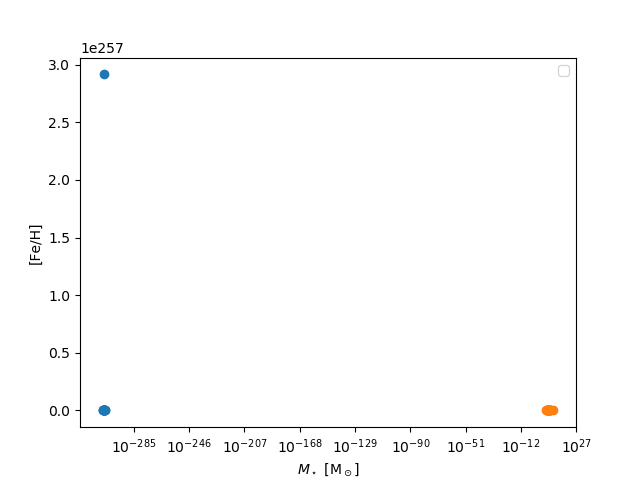

No handles with labels found to put in legend.


Text(0, 0.5, '[Fe/H]')

In [25]:
# Note that you may want to remove this matplotlib line
# if it makes the cell crash
%matplotlib nbagg

# Plot the metallicity as a function of stellar mass for all trees
plt.errorbar(gal_Mstar_1, gal_FeH_mean_1, yerr=gal_FeH_std_1, fmt='o')
plt.errorbar(gal_Mstar_2, gal_FeH_mean_2, yerr=gal_FeH_std_2, fmt='o')
plt.legend(loc='best')
plt.xscale('log')
plt.xlabel('$M_\star$ [M$_\odot$]')
plt.ylabel('[Fe/H]')

In [ ]:
# SAVE THE OUTPUT SOMEWHERE SOMEHOW

In [40]:
print(host_mdf)

(array([-6.  , -5.95, -5.9 , -5.85, -5.8 , -5.75, -5.7 , -5.65, -5.6 ,
       -5.55, -5.5 , -5.45, -5.4 , -5.35, -5.3 , -5.25, -5.2 , -5.15,
       -5.1 , -5.05, -5.  , -4.95, -4.9 , -4.85, -4.8 , -4.75, -4.7 ,
       -4.65, -4.6 , -4.55, -4.5 , -4.45, -4.4 , -4.35, -4.3 , -4.25,
       -4.2 , -4.15, -4.1 , -4.05, -4.  , -3.95, -3.9 , -3.85, -3.8 ,
       -3.75, -3.7 , -3.65, -3.6 , -3.55, -3.5 , -3.45, -3.4 , -3.35,
       -3.3 , -3.25, -3.2 , -3.15, -3.1 , -3.05, -3.  , -2.95, -2.9 ,
       -2.85, -2.8 , -2.75, -2.7 , -2.65, -2.6 , -2.55, -2.5 , -2.45,
       -2.4 , -2.35, -2.3 , -2.25, -2.2 , -2.15, -2.1 , -2.05, -2.  ,
       -1.95, -1.9 , -1.85, -1.8 , -1.75, -1.7 , -1.65, -1.6 , -1.55,
       -1.5 , -1.45, -1.4 , -1.35, -1.3 , -1.25, -1.2 , -1.15, -1.1 ,
       -1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65,
       -0.6 , -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 ,
       -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,
        0.3 ,  0.35